In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

In [2]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology/examples/07-DifferentialCFE-Model


# Attempt to Run Hybrid Model on 1 Basin

This will be based on Example 01, where we train on just 1 basin. 

## Training Hybrid

In [14]:

# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    print("GPU")
    start_run(config_file=Path("basin_hybrid.yml"))

# fall back to CPU-only mode
else:
    print("CPU")
    start_run(config_file=Path("basin_hybrid.yml"), gpu=-1)

CPU
2024-07-18 14:46:09,960: Logging to /Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology/examples/07-DifferentialCFE-Model/runs/testHybrid_run_1807_144609/output.log initialized.
2024-07-18 14:46:09,961: ### Folder structure created at /Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology/examples/07-DifferentialCFE-Model/runs/testHybrid_run_1807_144609
2024-07-18 14:46:09,962: ### Run configurations for testHybrid_run
2024-07-18 14:46:09,962: experiment_name: testHybrid_run
2024-07-18 14:46:09,962: train_basin_file: 1_basin.txt
2024-07-18 14:46:09,963: validation_basin_file: 1_basin.txt
2024-07-18 14:46:09,963: test_basin_file: 1_basin.txt
2024-07-18 14:46:09,964: train_start_date: 1999-10-01 00:00:00
2024-07-18 14:46:09,964: train_end_date: 2008-09-30 00:00:00
2024-07-18 14:46:09,965: validation_start_date: 1980-10-01 00:00:00
2024-07-18 14:46:09,96

Great! this is trained. What happened was the error keeps getting stuck on the x_conceptual input where the `x_conceptual[:,:,2]` and/or `x_conceptual[:,:,3]` do not exist. So the problem was with what files are being in-puted. We know that `x_conceptual[:,:,2]` is `tmin` and the other `tmax`, and `x_conceptual[:,:,0]` is `precip`. But no idea what `x_conceptual[:,:,1]` is, so I just put in a random one -- `srad`. It probably ins't super correct but I didn't spend time looking into what that value is supposed to be. 

## Evaluating Hybrid Model

Evaluate the trained model on the test set. 

In [15]:
run_dir = Path("runs/testHybrid_run_1807_144609")
eval_run(run_dir=run_dir, period="test")

2024-07-18 15:06:31,706: Using the model weights from runs/testHybrid_run_1807_144609/model_epoch050.pt
# Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]
2024-07-18 15:06:33,672: Stored metrics at runs/testHybrid_run_1807_144609/test/model_epoch050/test_metrics.csv
2024-07-18 15:06:33,673: Stored results at runs/testHybrid_run_1807_144609/test/model_epoch050/test_results.p


## Load n Inspect Hybrid Model Prediction

Load the results, double check it is the right basin. 

In [16]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp: # we only have 25 epoch max
    results = pickle.load(fp)
    
results.keys()

dict_keys(['01022500'])

In [17]:
results['01022500']['1D']['xr']

<xarray.Dataset> Size: 58kB
Dimensions:         (date: 3652, time_step: 1)
Coordinates:
  * date            (date) datetime64[ns] 29kB 1989-10-01 ... 1999-09-30
  * time_step       (time_step) int64 8B 0
Data variables:
    QObs(mm/d)_obs  (date, time_step) float32 15kB 0.6203 0.5537 ... 0.9992
    QObs(mm/d)_sim  (date, time_step) float32 15kB 0.839 0.7957 ... 1.885 1.396

Looks consistent. Now plot it.

Text(0.5, 1.0, 'Test period - NSE 0.513')

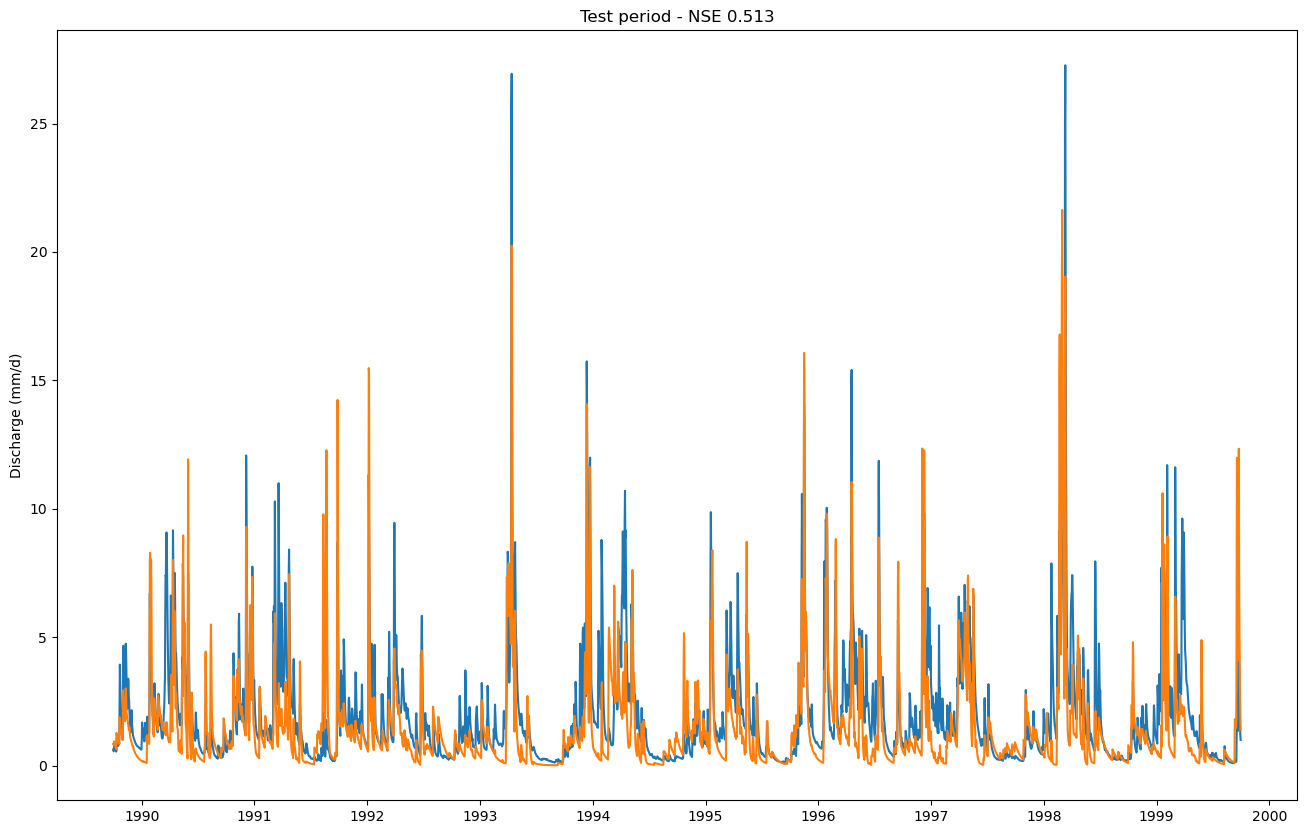

In [18]:
# extract observations and simulations
qobs = results['01022500']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['01022500']['1D']['xr']['QObs(mm/d)_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['01022500']['1D']['NSE']:.3f}")

Note that this is not as good as the default LSTM model (NSE = 0.788), with NSE = 0.513, but this might be due to choosing a randome 2nd forcing file. Now examine other metrics:

In [19]:
values = metrics.calculate_all_metrics(qobs.isel(time_step=-1), qsim.isel(time_step=-1))
for key, val in values.items():
    print(f"{key}: {val:.3f}")

NSE: 0.513
MSE: 2.397
RMSE: 1.548
KGE: 0.628
Alpha-NSE: 0.900
Beta-KGE: 0.726
Beta-NSE: -0.248
Pearson-r: 0.769
FHV: -0.624
FMS: 6.133
FLV: -115.575
Peak-Timing: 0.435
Peak-MAPE: 37.201


/Users/ziyu/miniconda3/envs/dCFE_env/lib/python3.12/site-packages/neuralhydrology/datautils/utils.py:327: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/ziyu/miniconda3/envs/dCFE_env/lib/python3.12/site-packages/neuralhydrology/datautils/utils.py:368: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


# Attempt to Run dCFE (updated 7/18/2024)

The `dcfe.py` file is going to function somewhat like `shm.py`, so it could be implemented using `hybrid_model`. The first goal is to get it to train. 

In [ ]:

# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    print("GPU")
    start_run(config_file=Path("basin_dCFE.yml"))

# fall back to CPU-only mode
else:
    print("CPU")
    start_run(config_file=Path("basin_dCFE.yml"), gpu=-1)